<a href="https://colab.research.google.com/github/FirangizSadiyeva/Covid-19/blob/main/Covid19_forecasting_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
import configparser
from datetime import timedelta
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [38]:
corona_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
corona_deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
corona_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [39]:
corona_confirmed_df=corona_confirmed_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_confirmed_df=corona_confirmed_df.rename({'variable':'Date','value':'confirmed'}, axis='columns')
corona_deaths_df=corona_deaths_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_deaths_df=corona_deaths_df.rename({'variable':'Date','value':'deaths'}, axis='columns')
corona_recovered_df=corona_recovered_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_recovered_df=corona_recovered_df.rename({'variable':'Date','value':'recovered'}, axis='columns')

In [40]:
combined_df = [corona_confirmed_df, corona_deaths_df, corona_recovered_df]
combined_df = [df.set_index(['Province/State','Country/Region','Lat','Long','Date']) for df in combined_df]
combined_df=combined_df[0].join(combined_df[1:])

In [41]:
combined_df=combined_df.reset_index()

In [42]:
combined_df[['Lat', 'Long', 'confirmed', 'deaths', 'recovered']] = combined_df[['Lat', 'Long', 'confirmed', 'deaths', 'recovered']].apply(pd.to_numeric)
combined_df[['Date']] = combined_df[['Date']].apply(pd.to_datetime)
combined_df[['confirmed']] = combined_df[['confirmed']].apply(np.int64)
combined_df[['deaths']] = combined_df[['deaths']].apply(np.int64)
combined_df[['recovered']] = combined_df[['recovered']].apply(np.int64)

In [43]:
combined_df=combined_df.rename({'Province/State':'State','Country/Region':'Country'}, axis ='columns')

In [44]:
print("Size/Shape of the dataset",combined_df.shape)
print("Checking for null values",combined_df.isnull().sum())
print("Checking Data-type", combined_df.dtypes)

Size/Shape of the dataset (101556, 8)
Checking for null values State        70308
Country          0
Lat            372
Long           372
Date             0
confirmed        0
deaths           0
recovered        0
dtype: int64
Checking Data-type State                object
Country              object
Lat                 float64
Long                float64
Date         datetime64[ns]
confirmed             int64
deaths                int64
recovered             int64
dtype: object


In [45]:
combined_df.to_csv("combined.csv")

In [59]:
combined_df.drop(["State"],1,inplace=True)

In [68]:
combined_df.isnull().sum()

Country        0
Lat          372
Long         372
Date           0
confirmed      0
deaths         0
recovered      0
dtype: int64

In [70]:
def pltCountry_cases_1(confirmed,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=combined_df.loc[(combined_df['Country']==a)]
        plt.plot(country['Date'],country['confirmed'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of confirmed_cases' )

In [71]:
def pltCountry_cases_2(recovered,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=combined_df.loc[(combined_df['Country']==a)]
        plt.plot(country['Date'],country['recovered'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of recovered_cases' )

In [72]:
def pltCountry_cases_3(deaths,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=combined_df.loc[(combined_df['Country']==a)]
        plt.plot(country['Date'],country['deaths'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of deaths_cases' )

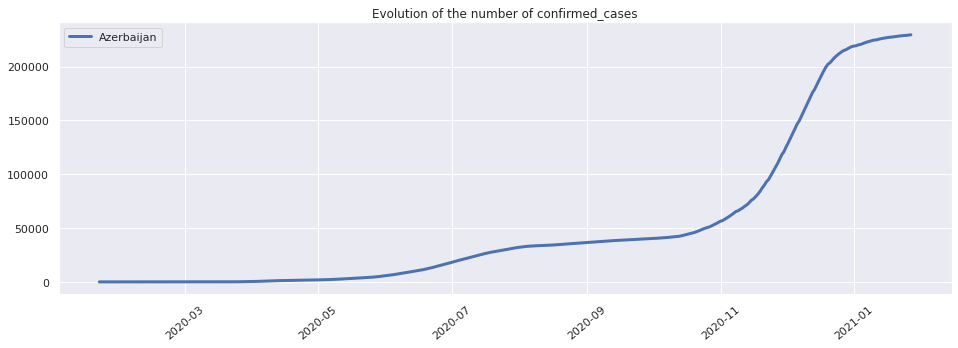

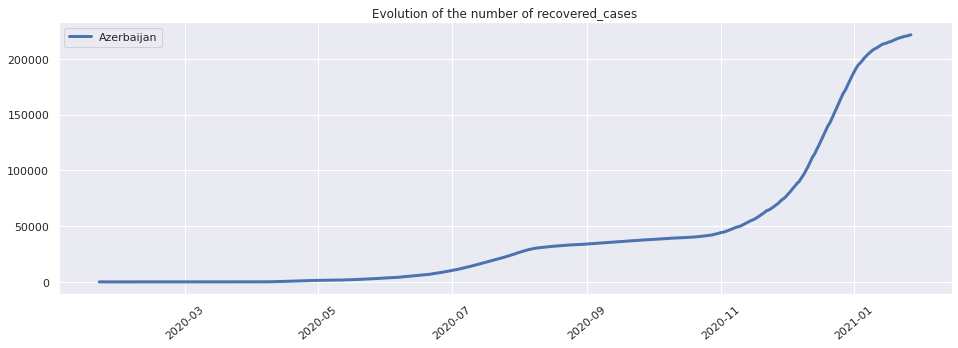

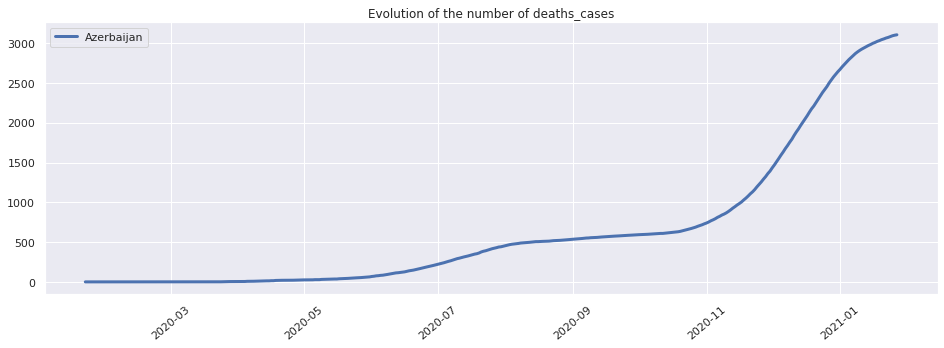

In [73]:
pltCountry_cases_1('confirmed','Azerbaijan')
pltCountry_cases_2('recovered','Azerbaijan')
pltCountry_cases_3('deaths','Azerbaijan')

In [74]:
combined_df= combined_df[combined_df['Country']=='Azerbaijan']
combined_df

,Country,Lat,Long,Date,confirmed,deaths,recovered
17,Azerbaijan,40.1431,47.5769,2020-01-22,0,0,0
290,Azerbaijan,40.1431,47.5769,2020-01-23,0,0,0
563,Azerbaijan,40.1431,47.5769,2020-01-24,0,0,0
836,Azerbaijan,40.1431,47.5769,2020-01-25,0,0,0
1109,Azerbaijan,40.1431,47.5769,2020-01-26,0,0,0
...,...,...,...,...,...,...,...
100208,Azerbaijan,40.1431,47.5769,2021-01-23,228688,3072,219724
100481,Azerbaijan,40.1431,47.5769,2021-01-24,228975,3082,220292
100754,Azerbaijan,40.1431,47.5769,2021-01-25,229032,3093,220565
101027,Azerbaijan,40.1431,47.5769,2021-01-26,229358,3100,221116


In [76]:
x = len(combined_df)-14

train=combined_df.iloc[:x]
test = combined_df.iloc[x:]

In [77]:
df = train.fillna('NA').groupby(['Country','Date'])['confirmed'].sum() \
                          .groupby(['Country']).max().sort_values() \
                          .groupby(['Country']).sum().sort_values(ascending = False)

top10 = pd.DataFrame(df).head(10)
top10

,confirmed
Country,
Azerbaijan,225820


In [78]:
fig = px.bar(top10, x=top10.index, y='confirmed', labels={'x':'Country'},
             color="confirmed", color_continuous_scale=px.colors.sequential.Brwnyl)
fig.update_layout(title_text='Confirmed COVID-19 cases by country')
fig.show()

In [79]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country','Date'])['confirmed'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country'] == 'Azerbaijan') &(df_by_date.Date >= '2020-03-01')].sort_values('confirmed',ascending = False), 
             x='Date', y='confirmed', color="confirmed", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in Azerbaijan')
fig.show()

In [80]:
df=train.groupby(['Date','Country']).agg('sum').reset_index()
df.tail(5)

,Date,Country,Lat,Long,confirmed,deaths,recovered
353,2021-01-09,Azerbaijan,40.1431,47.5769,224050,2890,207088
354,2021-01-10,Azerbaijan,40.1431,47.5769,224651,2909,208681
355,2021-01-11,Azerbaijan,40.1431,47.5769,224827,2926,209522
356,2021-01-12,Azerbaijan,40.1431,47.5769,225346,2941,210798
357,2021-01-13,Azerbaijan,40.1431,47.5769,225820,2957,212120


In [81]:
def pltCountry_cases(confirmed,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country']==a)]
        plt.plot(country['Date'],country['confirmed'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of cases' )

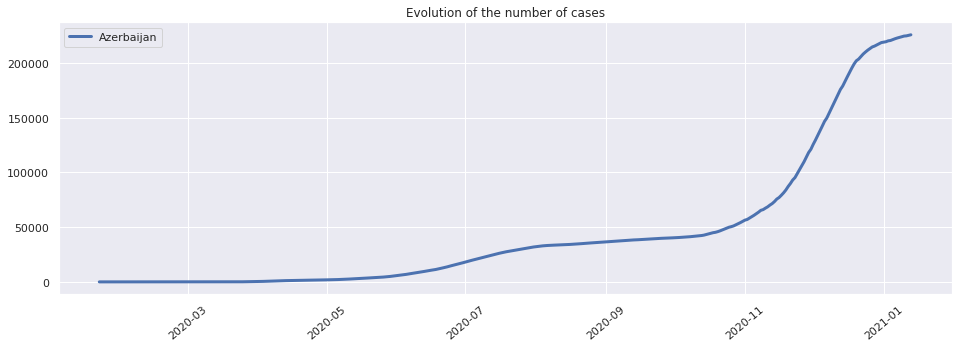

In [82]:
pltCountry_cases('confirmed','Azerbaijan')

In [83]:
test['Date'] = pd.to_datetime(test['Date'])
train['Date'] = pd.to_datetime(train['Date'])

In [84]:
case='confirmed'
def timeCompare(time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country']==Coun1)]
    plt.plot(country['Date'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country']==Coun2]
    #country2['Date']=country2['Date']-datetime.timedelta(days=time)
    plt.plot(country2['Date'],country2[case],linewidth=2)
    #plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of cases in %d days difference '%time ,ylabel='Number of %s cases'%case )

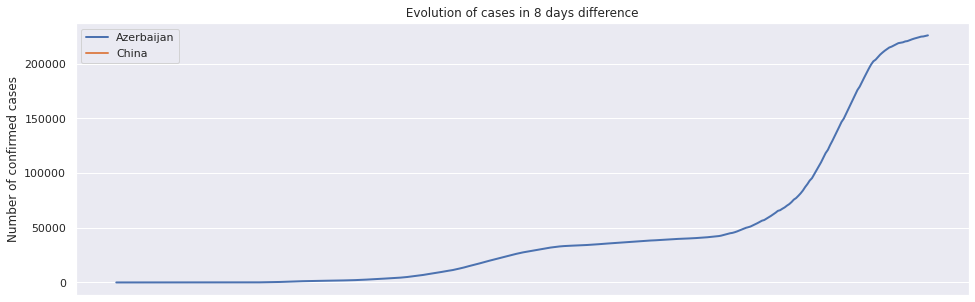

In [85]:
timeCompare(8,'Azerbaijan','China')

In [86]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='confirmed'):
    ts=df.loc[(df['Country']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['confirmed']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='confirmed'):
    ts=df.loc[(df['Country']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['confirmed']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Confirmed')
    plt.plot(ts[case])
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

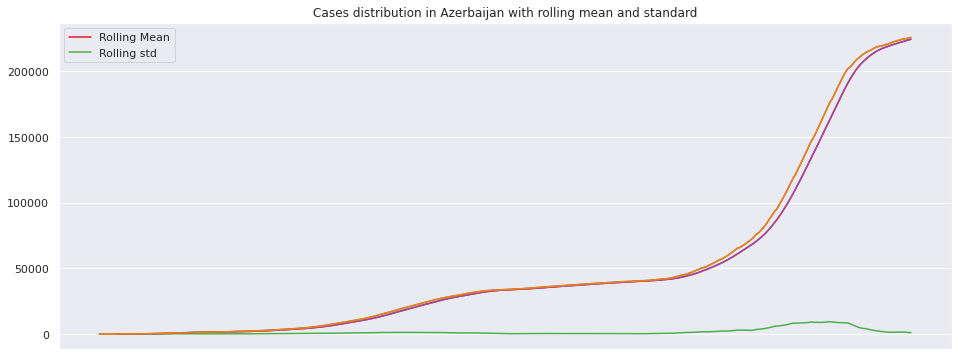

In [87]:
tsC1=roll('Azerbaijan')
rollPlot('Azerbaijan')

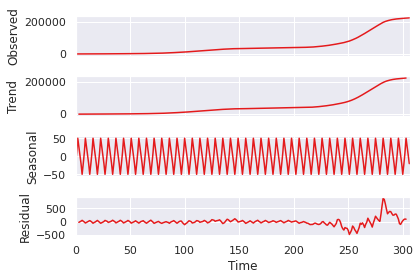

In [88]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC1.values,freq=7).plot()

In [89]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For Azerbaijan
tsC=tsC1['confirmed'].values
stationarity(tsC)

Results of Dickey-Fuller Test:
Test Statistic                   1.534179
p-value                          0.997646
#Lags Used                      15.000000
Number of Observations Used    291.000000
Critical Value (1%)             -3.453023
Critical Value (5%)             -2.871524
Critical Value (10%)            -2.572090
dtype: float64


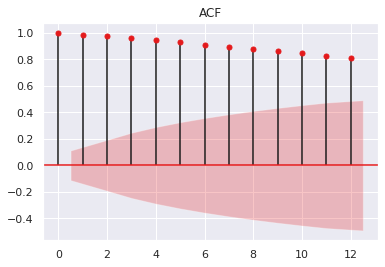

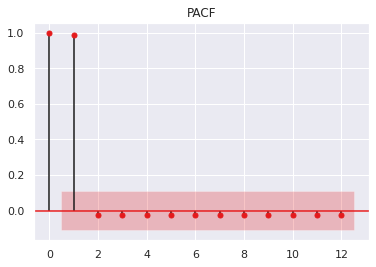

In [90]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    

#For Azerbaijan
corr(tsC1)

In [91]:
#test['Date'] = pd.to_datetime(test['Date'])
#train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index(['Date'])
test = test.set_index(['Date'])

In [92]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [93]:
train_features=pd.DataFrame(create_features(train))
test_features=pd.DataFrame(create_features(test))
features_and_target_train = pd.concat([train,train_features], axis=1)
features_and_target_test = pd.concat([test,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [94]:
x_train= features_and_target_train[['Country','month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
y1 = features_and_target_train[['confirmed']]
y2 =features_and_target_train[['recovered']]
x_test = features_and_target_test[['Country', 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']]

In [97]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    #return 1-(sum((y1-y_pred)**2)/sum((y_pred-np.mean(y_pred))**2))#R2
    return np.mean((y1-y_pred)**2)#MSE
    #return np.mean(abs(y1-y_pred))#MAE
    #return np.sqrt(np.mean((y1-y_pred)**2))#RMSE
    #return np.mean(np.abs((y1 - y_pred) / y1)) * 100 #MAPE 

"""    accuracy[j]=((abs(real[j]-result[j]))/real[j])*100
    #mse_f = np.mean((real[j]-result[j])**2)
    #mae_f = np.mean(abs(real[j]-result[j]))
    #rmse_f = np.sqrt(mse_f)
    #r2_f = 1-(sum((real[j]-result[j])**2)/sum((y-np.mean(y))**2))"""
def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,10)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param(3,2,4)
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMSE: %f'%mape(test,pred))
    return (pred)

In [ ]:
train,test=split(tsC)
pred=arima(train,test)